In [0]:
import numpy as np
from keras import models
from keras.models import Model, load_model
from keras import layers
from keras.layers import Dropout, Input
from keras import backend as K
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load encoder model

In [4]:
embedding_model = load_model('/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/MODEL_embedding.h5')
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 26, 26, 128)       0 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Model for female/male classification

In [0]:
def model_function(input_shape):

  base_input = Input(input_shape) 
  embedding_layers = embedding_model.layers[:-1]
  x1 = embedding_layers[0](base_input)
  for i in range(1,len(embedding_layers),1):
    x1 = embedding_layers[i](x1)

  x1 = layers.Dense(1, activation='sigmoid')(x1)

  model = Model(base_input, x1, name='female_male')

  for i in range(0,12,1):
    model.layers[i].trainable = False

  return model

In [99]:
model = model_function((224, 224, 3))
model.summary()

Model: "female_male"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 128)       

# Reading metadata

In [0]:
!cp -a "/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/croped_images_224" "/content/croped_images_224"
!cp -a "/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/metadata/metadata_small.npz" "/content/metadata_small.npz"

In [0]:
readed = np.load('/content/metadata_small.npz')
metadata = readed["metadata_small"]
x = metadata[:,0]
x = np.array(x, dtype='int64')
y = metadata[:,3]
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

!mkdir "/content/test"
!mkdir "/content/test/male"
!mkdir "/content/test/female"
!mkdir "/content/train"
!mkdir "/content/train/male"
!mkdir "/content/train/female"

for i in range(0,len(X_train),1):
  if(y_train[i]=="female"):
    shutil.copy("/content/croped_images_224/" + str(X_train[i]) + ".jpg", "/content/train/female/" + str(X_train[i]) + ".jpg")
  else: shutil.copy("/content/croped_images_224/" + str(X_train[i]) + ".jpg", "/content/train/male/" + str(X_train[i]) + ".jpg")
  
for i in range(0,len(X_test),1):
  if(y_test[i]=="female"):
    shutil.copy("/content/croped_images_224/" + str(X_test[i]) + ".jpg", "/content/test/female/" + str(X_test[i]) + ".jpg")
  else: shutil.copy("/content/croped_images_224/" + str(X_test[i]) + ".jpg", "/content/test/male/" + str(X_test[i]) + ".jpg")

# Generators

In [101]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = "/content/train"
test_dir = "/content/test"

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=30,
        class_mode='binary')

test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        batch_size=30,
        class_mode='binary')

Found 375 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


# Model training

In [145]:
model = model_function(input_shape = (224, 224, 3))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ["accuracy"])

history = model.fit(
              train_generator,
              steps_per_epoch=len(y_train)//20,
              epochs=30,
              validation_data=test_generator,
              validation_steps=len(y_test)//20)

Epoch 1/30
18/18 [==============================] - 2s 102ms/step - loss: 0.6405 - accuracy: 0.6324 - val_loss: 0.4840 - val_accuracy: 0.6645
Epoch 2/30
18/18 [==============================] - 1s 80ms/step - loss: 0.4451 - accuracy: 0.8078 - val_loss: 0.4852 - val_accuracy: 0.7548
Epoch 3/30
18/18 [==============================] - 2s 92ms/step - loss: 0.3581 - accuracy: 0.8667 - val_loss: 0.5853 - val_accuracy: 0.8129
Epoch 4/30
18/18 [==============================] - 2s 84ms/step - loss: 0.2710 - accuracy: 0.9510 - val_loss: 0.4643 - val_accuracy: 0.8710
Epoch 5/30
18/18 [==============================] - 1s 81ms/step - loss: 0.2426 - accuracy: 0.9505 - val_loss: 0.2764 - val_accuracy: 0.8846
Epoch 6/30
18/18 [==============================] - 2s 91ms/step - loss: 0.2150 - accuracy: 0.9600 - val_loss: 0.2281 - val_accuracy: 0.8774
Epoch 7/30
18/18 [==============================] - 1s 79ms/step - loss: 0.1812 - accuracy: 0.9686 - val_loss: 0.3057 - val_accuracy: 0.8774
Epoch 8/30
1

# Model loss and accuracy

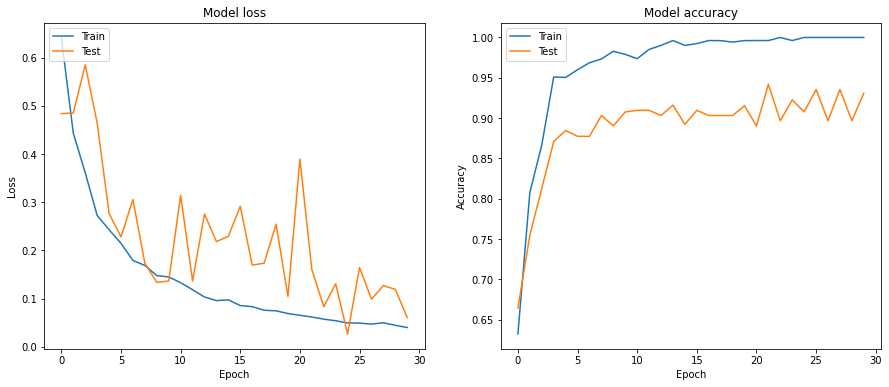

In [146]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [0]:
model.save("/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/MODEL_female_male_without_resnet.h5")

# Example of prediction

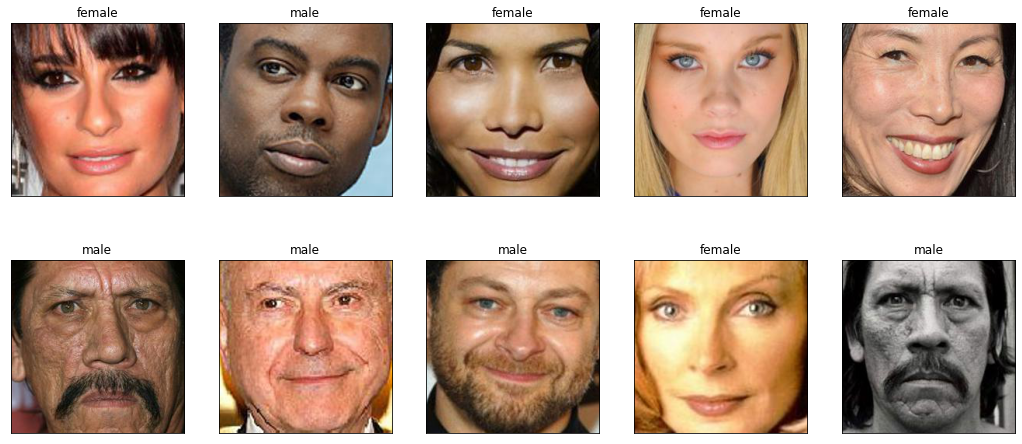

In [149]:
images = test_generator.next()[0]
images = images[:10]

labels = []
for i in range(0,len(images),1):
  if(model.predict(images[i:i+1]) < 0.5):
    labels.append("female")
  else: labels.append("male")

fix,axes = plt.subplots(2,5, figsize=(18,8), subplot_kw={'xticks':(),'yticks':()})
for img, label, ax in zip(images, labels, axes.ravel()):
    ax.imshow(img, cmap=plt.cm.binary)
    ax.set_title(label)

# Predictions on all test images

In [150]:
import os 
from skimage import io

num_true = 0
num_false = 0

file_names = os.listdir("/content/test/female")
for file in file_names:
  image = io.imread("/content/test/female/" + str(file))
  y_pred = model.predict(np.array([image])/255)
  if y_pred < 0.5:
    num_true+=1
  else: num_false+=1

file_names = os.listdir("/content/test/male")
for file in file_names:
  image = io.imread("/content/test/male/" + str(file))
  y_pred = model.predict(np.array([image])/255)
  if y_pred > 0.5:
    num_true+=1
  else: num_false+=1

print("num true: ", num_true)
print("num false: ", num_false)
print("Accuracy: {:.2f}%".format(num_true/((num_true+num_false)/100)))

num true:  116
num false:  9
Accuracy: 92.80%
